### Preprocessing
1. Set up the DataFrames etc.
2. Feature Extraction: Take the CQT of the chords
3. Test-Train Split

In [2]:
import os
import pandas as pd

def create_dataframe(folder_path, file_extension=".wav"):
    file_paths = []

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(file_extension):
                file_paths.append(os.path.join(root, file))

    df = pd.DataFrame(file_paths, columns=["File Path"])
    return df

# Replace 'your_folder_path' with the path to your main folder containing subfolders with WAV files
main_folder_path = 'data/chords'

# Replace '.wav' with your actual file extension if it's different
wav_dataframe = create_dataframe(main_folder_path, file_extension=".wav")

# Display the DataFrame
print(wav_dataframe)


                                  File Path
0       data/chords/aug/A-1-aug-chord-0.wav
1       data/chords/aug/A-1-aug-chord-1.wav
2       data/chords/aug/A-1-aug-chord-2.wav
3       data/chords/aug/A-2-aug-chord-0.wav
4       data/chords/aug/A-2-aug-chord-1.wav
...                                     ...
5003  data/chords/sus2/E-3-sus2-chord-2.wav
5004  data/chords/sus2/E-4-sus2-chord-0.wav
5005  data/chords/sus2/E-4-sus2-chord-1.wav
5006  data/chords/sus2/E-4-sus2-chord-2.wav
5007  data/chords/sus2/E-5-sus2-chord-0.wav

[5008 rows x 1 columns]


In [3]:
# go through every file path in the data frame and add a column with just the description of the chord, so everything between the last '/' and .wav
def get_chord_name(file_path):
    return file_path.split('/')[-1].split('.')[0]  # split the file path by '/' and take the last element, then split that by '.' and take the first element

# Apply the get_chord_name function to the 'File Path' column of the dataframe
wav_dataframe['Chord Name'] = wav_dataframe['File Path'].apply(get_chord_name)

# Display the updated DataFrame
print(wav_dataframe)

                                  File Path        Chord Name
0       data/chords/aug/A-1-aug-chord-0.wav   A-1-aug-chord-0
1       data/chords/aug/A-1-aug-chord-1.wav   A-1-aug-chord-1
2       data/chords/aug/A-1-aug-chord-2.wav   A-1-aug-chord-2
3       data/chords/aug/A-2-aug-chord-0.wav   A-2-aug-chord-0
4       data/chords/aug/A-2-aug-chord-1.wav   A-2-aug-chord-1
...                                     ...               ...
5003  data/chords/sus2/E-3-sus2-chord-2.wav  E-3-sus2-chord-2
5004  data/chords/sus2/E-4-sus2-chord-0.wav  E-4-sus2-chord-0
5005  data/chords/sus2/E-4-sus2-chord-1.wav  E-4-sus2-chord-1
5006  data/chords/sus2/E-4-sus2-chord-2.wav  E-4-sus2-chord-2
5007  data/chords/sus2/E-5-sus2-chord-0.wav  E-5-sus2-chord-0

[5008 rows x 2 columns]


In [4]:
# now I want to take every chord name and split it into the root note, quality and inversion, the names have the format '{root_note}-{octave}-{quality}-chord-{inversion}'

def get_chord_components(chord_name):
    chord_components = chord_name.split('-')
    return chord_components

# apply the function to the 'Chord Name' column of the dataframe and make the results into the following columns based on the following 
# positions in the returned array: 0 - 'Root Note', 1 - 'Octave', 2 - 'Quality', 4 - 'Inversion' 
results = pd.DataFrame(wav_dataframe['Chord Name'].apply(get_chord_components).tolist(), index=wav_dataframe.index)

wav_dataframe[['Root Note', 'Octave', 'Quality', 'Inversion']] = results[[0, 1, 2, 4]]

# Display the updated DataFrame
print(wav_dataframe)

                                  File Path        Chord Name Root Note  \
0       data/chords/aug/A-1-aug-chord-0.wav   A-1-aug-chord-0         A   
1       data/chords/aug/A-1-aug-chord-1.wav   A-1-aug-chord-1         A   
2       data/chords/aug/A-1-aug-chord-2.wav   A-1-aug-chord-2         A   
3       data/chords/aug/A-2-aug-chord-0.wav   A-2-aug-chord-0         A   
4       data/chords/aug/A-2-aug-chord-1.wav   A-2-aug-chord-1         A   
...                                     ...               ...       ...   
5003  data/chords/sus2/E-3-sus2-chord-2.wav  E-3-sus2-chord-2         E   
5004  data/chords/sus2/E-4-sus2-chord-0.wav  E-4-sus2-chord-0         E   
5005  data/chords/sus2/E-4-sus2-chord-1.wav  E-4-sus2-chord-1         E   
5006  data/chords/sus2/E-4-sus2-chord-2.wav  E-4-sus2-chord-2         E   
5007  data/chords/sus2/E-5-sus2-chord-0.wav  E-5-sus2-chord-0         E   

     Octave Quality Inversion  
0         1     aug         0  
1         1     aug         1  
2  

In [7]:
# remove the Chord Name column
wav_dataframe = wav_dataframe.drop(columns=['Chord Name'])

# # create a training and test set with a 70:30 split, stratified by the chord quality
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(wav_dataframe, test_size=0.3, random_state=42, stratify=wav_dataframe['Quality'])

# Display the number of rows in each set
print("Training set rows:", len(train_set))
print("Test set rows:", len(test_set))

Training set rows: 3505
Test set rows: 1503


In [2]:
# save these dataframes to csv files
train_set.to_csv('data/train_set.csv', index=False)
test_set.to_csv('data/test_set.csv', index=False)

NameError: name 'train_set' is not defined

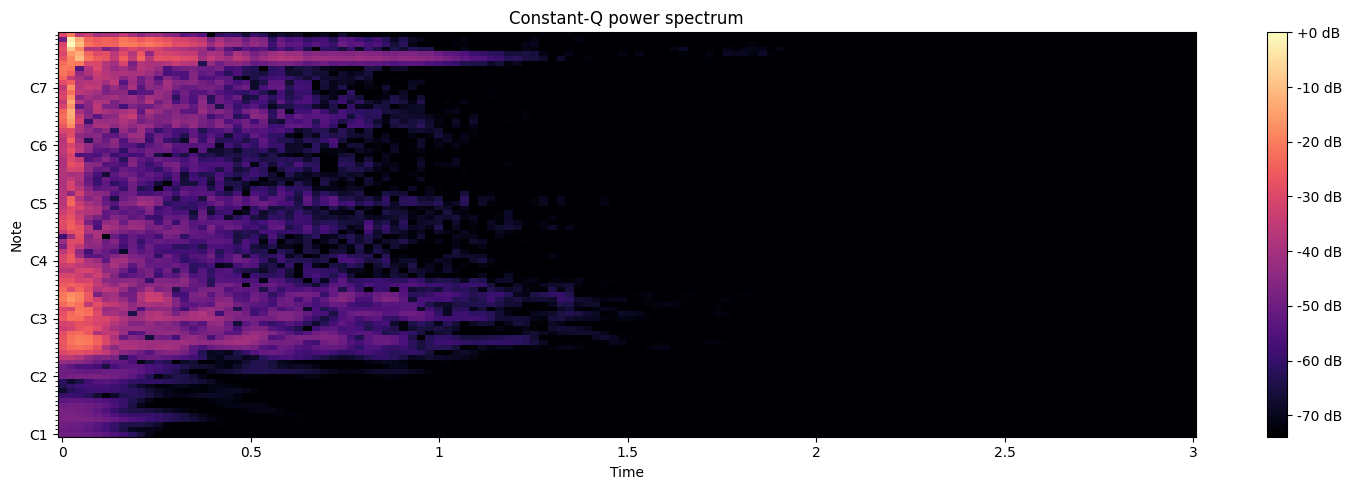

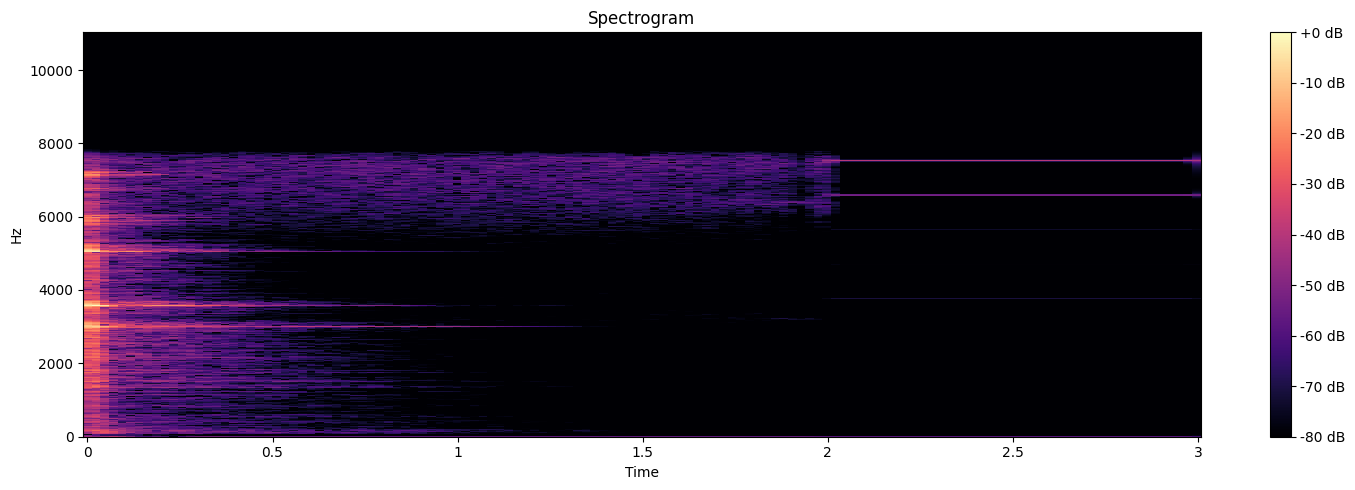

In [2]:
# write a function that calculates the constant q-transform of a wav file
import numpy as np
import librosa

def get_cqt(wav_file_path, sr=22050, hop_length=512, bins_per_octave=12, n_bins=7*12, fmin=librosa.note_to_hz('C1')):
    y, sr = librosa.load(wav_file_path, sr=sr)
    cqt = np.abs(librosa.cqt(y=y, sr=sr, hop_length=hop_length, bins_per_octave=bins_per_octave, n_bins=n_bins, fmin=fmin))
    return cqt

# calculate the cqt of the first file in the training set
cqt = get_cqt(train_set['File Path'].iloc[0])

# write a function that finds the spectrogram of a wav file
def get_spectrogram(wav_file_path, sr=22050, hop_length=512):
    y, sr = librosa.load(wav_file_path, sr=sr)
    spectrogram = np.abs(librosa.stft(y, hop_length=hop_length))
    return spectrogram

# calculate the spectrogram of the first file in the training set
spectrogram = get_spectrogram(train_set['File Path'].iloc[0])

# plot the cqt
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(15, 5))
librosa.display.specshow(librosa.amplitude_to_db(cqt, ref=np.max), sr=22050, hop_length=512, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()
plt.show()

# plot the spectrogram
plt.figure(figsize=(15, 5))
librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), sr=22050, hop_length=512, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.tight_layout()
plt.show()


In [1]:
# read train_set and test_set back into dataframes
import pandas as pd
train_set = pd.read_csv('data/train_set.csv')
test_set = pd.read_csv('data/test_set.csv')

In [3]:
# for every file path in the training set, calculate the cqt and the spectrogram, save these images and add the file paths to a column of the pandas dataframe:
# Path: create_images.py
import gc
import matplotlib.pyplot as plt
import librosa
import numpy as np
import os

def create_images(dataframe, image_folder_path="data/images", sr=22050, hop_length=512, bins_per_octave=12, n_bins=7*12, fmin=librosa.note_to_hz('C1')):
    for index, row in dataframe.iterrows():
        file_path = row['File Path']
        chord_name = str(row['Root Note']) + '-' + str(row['Octave']) + '-' + str(row['Quality']) + '-' + str(row['Inversion'])
        image_file_path = os.path.join(image_folder_path, chord_name + '.png')
        if not os.path.exists(image_file_path):
            # cqt = get_cqt(file_path, sr=sr, hop_length=hop_length, bins_per_octave=bins_per_octave, n_bins=n_bins, fmin=fmin)
            spectrogram = get_spectrogram(file_path, sr=sr, hop_length=hop_length)
            plt.figure(figsize=(15, 5))

            ### USING CQT
            # librosa.display.specshow(librosa.amplitude_to_db(cqt, ref=np.max), sr=sr, hop_length=hop_length, x_axis='time', y_axis='cqt_note')
            # plt.colorbar(format='%+2.0f dB')
            # plt.title('Constant-Q power spectrum')
            # plt.tight_layout()
            # plt.savefig(image_file_path)
            # plt.close()
            # plt.figure(figsize=(15, 5))


            ### USING SPECTOGRAM
            librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear')
            plt.colorbar(format='%+2.0f dB')
            plt.title('Spectrogram')
            plt.tight_layout()
            plt.savefig(image_file_path)
            plt.close()

            # cqt = None  # Release memory
            spectrogram = None  # Release memory


        dataframe.at[index, 'Image File Path'] = image_file_path
        gc.collect()  # Manually trigger garbage collection to clear memory
    return dataframe

# create the images for the entire set
train_set = create_images(train_set)
test_set = create_images(test_set)


In [6]:
# display the first 5 rows of the training set
print(train_set.head())

                                    File Path Root Note  Octave Quality  \
0        data/chords/dim/Eb-7-dim-chord-1.wav        Eb       7     dim   
1   data/chords/min7b5/C-3-min7b5-chord-1.wav         C       3  min7b5   
2       data/chords/dim7/E-6-dim7-chord-0.wav         E       6    dim7   
3        data/chords/min/Bb-5-min-chord-0.wav        Bb       5     min   
4  data/chords/maj7_2/Ab-5-maj7_2-chord-0.wav        Ab       5  maj7_2   

   Inversion  
0          1  
1          1  
2          0  
3          0  
4          0  


In [7]:
# for ever image in data/images, read the name of the file and add it into a dataframe
# Path: create_image_dataframe.py
import os
import pandas as pd

def create_image_dataframe(folder_path, file_extension=".png"):
    file_paths = []

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(file_extension):
                file_paths.append(os.path.join(root, file))

    df = pd.DataFrame(file_paths, columns=["Image File Path"])
    return df

# Replace 'your_folder_path' with the path to your main folder containing subfolders with WAV files
main_folder_path = 'data/images'

# Replace '.wav' with your actual file extension if it's different
image_dataframe = create_image_dataframe(main_folder_path, file_extension=".png")

# go through every image file path in the data frame, and add a column with just the description of the chord, so everything between the last '/' and .png
def get_chord_name(image_file_path):
    return image_file_path.split('/')[-1].split('.')[0]  # split the file path by '/' and take the last element, then split that by '.' and take the first element

# Apply the get_chord_name function to the 'Image File Path' column of the dataframe
image_dataframe['Chord Name'] = image_dataframe['Image File Path'].apply(get_chord_name)

# take the Chord Name column and split it into the root note, octave, quality and inversion, the names have the format '{root_note}-{octave}-{quality}-chord-{inversion}'
def get_chord_components(chord_name):
    chord_components = chord_name.split('-')
    return chord_components

# apply the function to the 'Chord Name' column of the dataframe and make the results into the following columns based on the following
# positions in the returned array: 0 - 'Root Note', 1 - 'Octave', 2 - 'Quality', 3 - 'Inversion'
results = pd.DataFrame(image_dataframe['Chord Name'].apply(get_chord_components).tolist(), index=image_dataframe.index)

image_dataframe[['Root Note', 'Octave', 'Quality', 'Inversion']] = results[[0, 1, 2, 3]]

# Display the updated DataFrame
print(image_dataframe.head())

                 Image File Path     Chord Name Root Note Octave Quality  \
0     data/images/Eb-7-dim-1.png     Eb-7-dim-1        Eb      7     dim   
1   data/images/C-3-min7b5-1.png   C-3-min7b5-1         C      3  min7b5   
2     data/images/E-6-dim7-0.png     E-6-dim7-0         E      6    dim7   
3     data/images/Bb-5-min-0.png     Bb-5-min-0        Bb      5     min   
4  data/images/Ab-5-maj7_2-0.png  Ab-5-maj7_2-0        Ab      5  maj7_2   

  Inversion  
0         1  
1         1  
2         0  
3         0  
4         0  


### Model 1: Use a basic CNN to predict Root Note + Quality for just maj, min, dim, aug Chords

In [8]:
# remove all the rows that have a quality other than maj, min, dim, aug
image_dataframe = image_dataframe[image_dataframe['Quality'].isin(['maj', 'min', 'dim', 'aug'])]

# remove the Chord Name column
image_dataframe = image_dataframe.drop(columns=['Chord Name'])

print(image_dataframe.head())

               Image File Path Root Note Octave Quality Inversion
0   data/images/Eb-7-dim-1.png        Eb      7     dim         1
3   data/images/Bb-5-min-0.png        Bb      5     min         0
20  data/images/Ab-3-maj-1.png        Ab      3     maj         1
28  data/images/Ab-2-aug-0.png        Ab      2     aug         0
32   data/images/G-4-aug-1.png         G      4     aug         1


In [9]:
# split into a train and test set with a 70:30 split, stratified by the chord quality
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(image_dataframe, test_size=0.3, random_state=42, stratify=image_dataframe['Quality'])

In [10]:
# save train_set and test_set to csv files
train_set.to_csv('data/image_train_set.csv', index=False)
test_set.to_csv('data/image_test_set.csv', index=False)

In [1]:
# read train_set and test_set back into dataframes
import pandas as pd
train_set = pd.read_csv('data/image_train_set.csv')
test_set = pd.read_csv('data/image_test_set.csv')

# get the dimensions of the first image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(train_set['Image File Path'].iloc[0])
print(img.shape)


(500, 1500, 4)


In [5]:
# create a convolutional neural network to classify the chord images
import tensorflow as tf

# remove all the rows that have a quality other than maj, min, dim, aug
train_set = train_set[train_set['Quality'].isin(['maj', 'min', 'dim'])]
test_set = test_set[test_set['Quality'].isin(['maj', 'min', 'dim'])]

# print the number of rows of each quality
print(train_set['Quality'].value_counts())
print(test_set['Quality'].value_counts())


# create a new column that combines the root note and the quality
train_set['Root Note and Quality'] = train_set['Root Note'] + '-' + train_set['Quality']
test_set['Root Note and Quality'] = test_set['Root Note'] + '-' + test_set['Quality']

from sklearn.preprocessing import LabelEncoder

# create a label encoder
le = LabelEncoder()

# fit the encoder on the training labels
le.fit(train_set['Quality'])

def create_dataset(dataframe, batch_size=32, image_size=(250, 750)):  # Adjust the image size here
    def load_and_preprocess_image(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_png(image, channels=4)
        image = tf.image.resize(image, image_size)
        image /= 255.0  # normalize pixel values
        return image, label

    # transform the labels into integers
    labels = le.transform(dataframe['Quality'].values)

    dataset = tf.data.Dataset.from_tensor_slices((dataframe['Image File Path'].values, labels))
    dataset = dataset.map(load_and_preprocess_image)
    dataset = dataset.batch(batch_size)
    return dataset

# create the training and test datasets
train_dataset = create_dataset(train_set)
test_dataset = create_dataset(test_set)

# create the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(250, 750, 4)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train the model
model.fit(train_dataset, epochs=10)


Quality
min    179
dim    179
maj    178
Name: count, dtype: int64
Quality
maj    77
min    76
dim    76
Name: count, dtype: int64
Epoch 1/10
17/17 [==============================] - 1257s 78s/step - loss: 8.0105 - accuracy: 0.3563
Epoch 2/10
17/17 [==============================] - 74s 4s/step - loss: 1.0986 - accuracy: 0.3340
Epoch 3/10
17/17 [==============================] - 74s 4s/step - loss: 1.0986 - accuracy: 0.3340
Epoch 4/10
17/17 [==============================] - 73s 4s/step - loss: 1.0986 - accuracy: 0.3340
Epoch 5/10
17/17 [==============================] - 72s 4s/step - loss: 1.0986 - accuracy: 0.3340
Epoch 6/10
17/17 [==============================] - 72s 4s/step - loss: 1.0986 - accuracy: 0.3340
Epoch 7/10
17/17 [==============================] - 76s 4s/step - loss: 1.0986 - accuracy: 0.3340
Epoch 8/10
17/17 [==============================] - 76s 4s/step - loss: 1.0986 - accuracy: 0.3340
Epoch 9/10
17/17 [==============================] - 76s 4s/step - loss: 1.0986 - a

In [6]:
# evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print('Test loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))


8/8 [==============================] - 6s 609ms/step - loss: 1.0986 - accuracy: 0.3319
Test loss: 1.10. Test accuracy: 33.19%
